# README
Do not blindly copy and paste. The parameter is hard-fixed with the `dataset`.<br>
For example: `SEQUENCE_LENGTH`

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm

torch.manual_seed(1249583)

# See the details in `Dataset` section
SEQUENCE_LENGTH = 19
COUNTRY_LENGTH = 18


# Data Preparation

<img src='lesson13_data.png'>

In [5]:
def str2ascii_arr(name):
    """
    0-255
    """
    arr = [ord(c) for c in name]
    return arr, len(arr)

In [44]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, output_size=18, n_layers=1):
        """
        Because word embedding is working with ascii. It has to use `input_size=256, hidden_size=256`
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        # input_size 256, hidden_size 256.
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        """
        Do not remove `print`. Leave it be a historical footprint for I myself in the future
        """
        
        # Sung Kim run this all at once (over the whole input sequence)
        # input = B x S . size(0) = B
        batch_size = input.size(0)
        
        # input: B x S -- (transpose) --> S x B
        input = input.t()
        
        # Embedding S x B -> S x B x I (embedding size)
        # print(f" input size: {input.size()}")
        embedded = self.embedding(input)
        embedded = embedded.clone().detach() # Make new tensor because of `EmbeddingGrad`
        # print(f" embeddding size: {embedded.size()}")
        
        # Make a hidden
        hidden = self._init_hidden(batch_size)
        output, hidden = self.gru(embedded, hidden)
        # print(f" gru hidden output: {hidden.size()}")
        
        # Use last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden)
        # print(f" fc output: {fc_output.size()}")
        return fc_output
        
    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return hidden.clone().detach()

In [7]:
# in torch.Size([1, 6]) 'adylov'
# out torch.Size([1, 1, 18]) 18 countries

# Zero padding

<img src='zero_padding.png'>

In [8]:
def pad_sequences(vectorized_seqs, seq_lengths):
    """
    Let the `SEQUENCE_LENGTH` is 19. According to the dataset
    """
    seq_tensor = torch.zeros((len(vectorized_seqs), SEQUENCE_LENGTH), dtype=torch.long)
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.tensor(seq, dtype=torch.long)
    return seq_tensor

In [9]:
def make_variables(names):
    sequence_and_length = [str2ascii_arr(name) for name in names]
    vectorized_seqs = [sl[0] for sl in sequence_and_length]
    seq_lengths = torch.tensor([sl[1] for sl in sequence_and_length])
    return pad_sequences(vectorized_seqs, seq_lengths)

In [10]:
make_variables(['az', 'ab '])

tensor([[ 97, 122,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [ 97,  98,  32,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0]])

In [11]:
classifier = RNNClassifier()
arr, _ = str2ascii_arr('adylov')
inp = torch.tensor([arr], dtype=torch.long)
out = classifier(inp)
print(f"\nin: {inp.size()}, \nout: {out.size()}")


in: torch.Size([1, 6]), 
out: torch.Size([1, 1, 18])


In [12]:
names = ['adylov', 'solan', 'hard', 'san']
classifier = RNNClassifier()
inputs = make_variables(names)
out = classifier(inputs)
print(f"\nbatch in: {inputs.size()}, \nbatch out: {out.size()}")


batch in: torch.Size([4, 19]), 
batch out: torch.Size([1, 4, 18])


# Utilities

In [45]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    This function has one line different from the ordinary `train()` function
    It has `make_variables()` to convert tuple of names to be a tensor
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        # Do not forget to convert the tuple of string to a tensor
        data = make_variables(data)
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        tmp = output.view(-1, COUNTRY_LENGTH)
        loss = criterion(tmp, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = make_variables(data)
            data, target = data.to(device), target.to(device)
            output = model(data)
            tmp = output.view(-1, COUNTRY_LENGTH)
            
            test_loss += criterion(tmp, target).item() # sum up batch loss
            pred = tmp.max(1, keepdim=True)[1] # get the index of the max log-probability

            pred_tmp = pred.view(-1)
            pred_list = pred_tmp.tolist()
            target_list = target.tolist()
            
            y_test += target_list
            y_pred += pred_list
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=countries, normalize=True,
                          title='Confusion matrix')


# Dataset

In [168]:
trainset = pd.read_csv('names_train.csv', header=None)
testset = pd.read_csv('names_test.csv', header=None) 

In [169]:
headers = ['name', 'country']
trainset.columns = headers
testset.columns = headers

In [170]:
countries = sorted(list(trainset.country.drop_duplicates()))

In [171]:
country_counting = trainset.country.value_counts()

In [172]:
country_counting

Russian       6272
English       2445
Arabic        1333
Japanese       660
German         482
Italian        472
Czech          346
Spanish        198
Dutch          198
French         184
Chinese        178
Irish          154
Greek          135
Polish          92
Scottish        66
Korean          62
Portuguese      49
Vietnamese      48
Name: country, dtype: int64

In [173]:
counting_df = pd.DataFrame(country_counting)

In [174]:
counting_df.loc['Russian']['country']

6272

In [178]:
counting_df['ratio'] = (counting_df.country.sum())/counting_df['country']

Use at `CrossEntropy` weights

In [179]:
counting_df

,country,ratio
Russian,6272,2.132334
English,2445,5.469939
Arabic,1333,10.033008
Japanese,660,20.263636
German,482,27.746888
Italian,472,28.334746
Czech,346,38.653179
Spanish,198,67.545455
Dutch,198,67.545455
French,184,72.684783


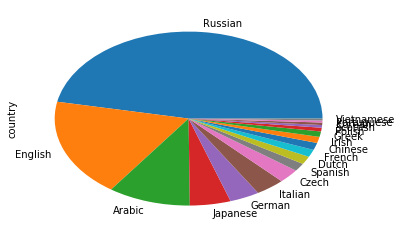

In [22]:
# Majority of dataset is `Russian`
trainset.country.value_counts().plot.pie()

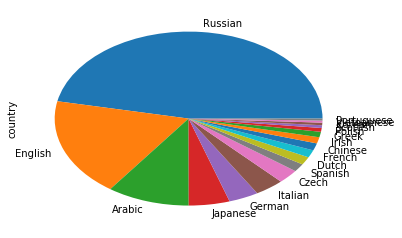

In [24]:
# So as trainset
testset.country.value_counts().plot.pie()

In [25]:
trainset.iloc[0]['country']

'Czech'

# Find the longest name in the dataset

In [26]:
result = pd.concat([trainset, testset])

In [27]:
result['name_length'] = result.name.apply(lambda x:  len(x))

## Longest name is 19 chars
19 is the `sequence_length`

In [28]:
result['name_length'].max(), result['name_length'].idxmax()

(19, 7925)

In [29]:
result.iloc[7925]

name           ShirinskyShikhmatov
country                    Russian
name_length                     19
Name: 7925, dtype: object

In [117]:
class NameDataSet(Dataset):
    def __init__(self, filename='names_train.csv'):
        trainset = pd.read_csv('names_train.csv', header=None)
        trainset.columns = ['name', 'country']
        countries = sorted(list(trainset.country.drop_duplicates()))

        self.trainset = trainset
        self.countries = countries
        self.len = len(trainset)        

    def __getitem__(self, index):
        country = self.trainset.iloc[index]['country']
        return self.trainset.iloc[index]['name'], self.countries.index(country)

    def __len__(self):
        return self.len
        

In [31]:
train_dataset = NameDataSet()
test_dataset = NameDataSet('names_test.csv')

In [32]:
train_dataset.countries.index('Czech')

0

In [33]:
train_loader = DataLoader(dataset=train_dataset, batch_size=2, num_workers=2, shuffle=True) # 2 * 9 * 743 
test_loader = DataLoader(dataset=test_dataset, batch_size=2, num_workers=2) # 4 * 25 * 67

# 1. Model

In [202]:
model = RNNClassifier()

# 2. Criterion & Loss
Loss is absorbed in the `test() and train()` already

In [203]:
weight_list = [counting_df.loc[country]['ratio'] for country in countries]

In [204]:
weights = torch.tensor(weight_list, dtype=torch.float)

In [205]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train Epoch: 1 [0/13374 (0%)]	Loss: 2.906743
Train Epoch: 1 [2000/13374 (15%)]	Loss: 2.284280
Train Epoch: 1 [4000/13374 (30%)]	Loss: 0.172735
Train Epoch: 1 [6000/13374 (45%)]	Loss: 1.122539
Train Epoch: 1 [8000/13374 (60%)]	Loss: 2.409602
Train Epoch: 1 [10000/13374 (75%)]	Loss: 0.144802
Train Epoch: 1 [12000/13374 (90%)]	Loss: 2.147868




Test set: Average loss: 0.4217, Accuracy: 10226/13374 (76%)

[[  19    9    2   17    1    0   94    0    0  112    1    2   39    0
     0    8    1   41]
 [   1   73    3    1    2    0   18    0    0  282    2    3    9    0
     0   50    0   38]
 [   0    0 1115    0    0    0   22    0    0   59   12   57   31    0
     0   14    0   23]
 [   0    1   14  545    1    2   19    0    0   21    5    0   47    0
     0    0    4    1]
 [   2    0    2    5   45   24   15    0    0   31    0    1    8    0
     0   12   33    0]
 [   0    1    1    1    5   11    1    0    0   17    0    0    3    0
     0    0    8    0]
 [   3   47   10   47    3    2 5586    1    0  377    3   14   96    0
     0   21   11   51]
 [   0    5    0    0    0    0    7    1    0  134    0    5   14    0
     0    9    0    9]
 [   1    0    0    0    3    0   11    0   13  117    1    0    3    0
     0    5    0    0]
 [   2   12   16    8   10    1   67    2    2 2186    3   13   18    0
     0   6

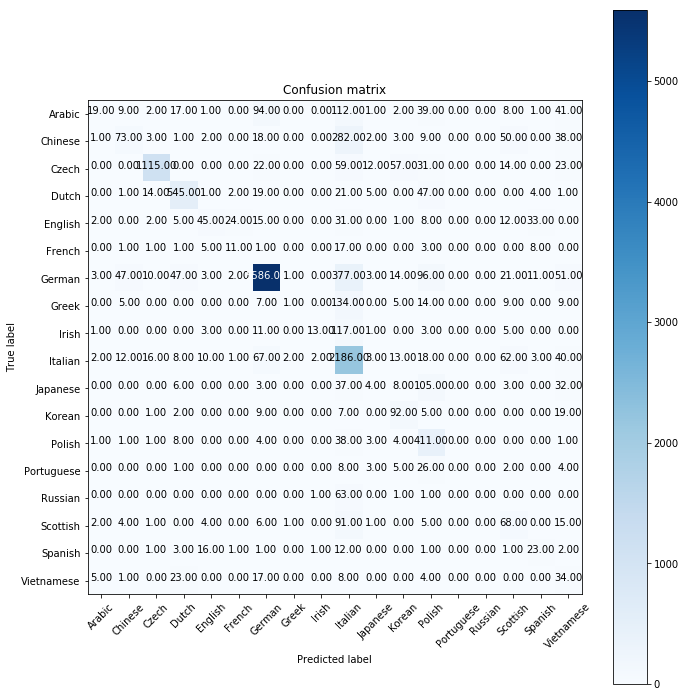

In [206]:
for epoch in range(1, 1 + 1):
    train(model, 'cpu', train_loader, optimizer, epoch, criterion)
    test(model, 'cpu', test_loader, criterion)

# Experiment Notes

1. Linear layer either one layer or two layers. No impact on confusion matrix. It still blindly guess `Russian`

# Scratch Note

In [125]:
weight = torch.tensor([3, 1, 1], dtype=torch.float)

In [126]:
loss = nn.CrossEntropyLoss(weight=weight)

In [127]:
Y = torch.tensor([2, 0, 1], dtype=torch.long)
y_pred1 = torch.tensor([
    [.1 ,.2, .9],
    [1.1, .1, .2],
    [0.2, 2.1, .1]
])
y_pred2 = torch.tensor([
    [0.8, .2, .3],
    [.2, .3, .5],
    [.2, .2, .1],
])

In [128]:
l1 = loss(y_pred1, Y)
l1

tensor(0.5274)

In [129]:
l2 = loss(y_pred2, Y)
l2

tensor(1.2108)